<a href="https://colab.research.google.com/github/kdemertzis/Earthquakes/blob/main/ITSAK/neuron_networks_to_equation_itsak_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

17/17 [==============================] - 0s 2ms/step
R-squared: -0.007012614185045729
Mean squared error: 0.037552443472197175


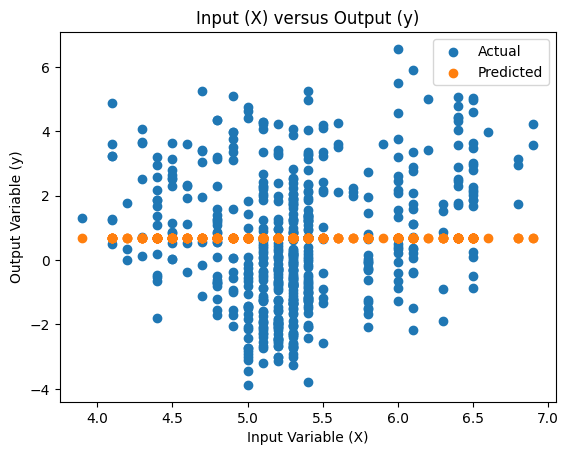

In [27]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_squared_error
from numpy import asarray
import re
import sympy
np.set_printoptions(suppress=True)

# Load the earthquake dataset
data = pd.read_csv('https://raw.githubusercontent.com/kdemertzis/Earthquakes/main/ITSAK/ln_1_no_titles.csv')

# Split the data into input and output arrays
X = data.iloc[:, :-1].values # Select all columns except the last
y = data.iloc[:, -1].values  # Select the last column as the output

scale_X = MinMaxScaler()
X = scale_X.fit_transform(X)
scale_y = MinMaxScaler()
y = scale_y.fit_transform(y.reshape(-1,1))

# Split the data into training and testing data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define and run model
model = Sequential()
model.add(Dense(1, input_dim=4, activation='tanh', kernel_initializer='he_uniform'))
model.add(Dense(1, name='Output'))

model.compile(loss='mse', optimizer='adam')
model.fit(X_train, y_train, epochs=200, batch_size=10, verbose=0)

# Predict on test set
yhat = model.predict(X_test)

# Inverse transforms
X_plot = scale_X.inverse_transform(X_test)
y_plot = scale_y.inverse_transform(y_test)
yhat_plot = scale_y.inverse_transform(yhat)

# Print evaluation metrics
print("R-squared:", r2_score(y_test, yhat))
print("Mean squared error:", mean_squared_error(y_test, yhat))

# Plot X_test vs y_test and yhat
plt.scatter(X_plot[:, 0], y_plot, label='Actual')
plt.scatter(X_plot[:, 0], yhat_plot, label='Predicted')
plt.title('Input (X) versus Output (y)')
plt.xlabel('Input Variable (X)')
plt.ylabel('Output Variable (y)')
plt.legend()
plt.show()


In [28]:
### Conversion to Basic Formula

# temp list as a container for each layer formulas
formula_list = []
# counter of hidden layers
f_n = 1
#
for i in range(len(model.layers)):
    # get ith Keras layer's weights and biases
    layer = model.layers[i]
    W = layer.get_weights()
    # empty text string to which concatenate current layer formula parts
    formula = ''
    # set script for input layer
    if i == 0:
        for i in range(W[0].shape[1]):
            cur_weight = np.sum(W[0][0,i])
            cur_bias = np.sum(W[1][i])
            # build formula for this layer
            formula += '*'+str(np.round(cur_weight,2))+'*'+'x+'+'*'+str(np.round(cur_bias,2)) + '*'+ '/'
        # append this layer formula to temp list
        formula_list.append(formula)

    # set script for hidden layers
    elif i < len(model.layers)-1:
        # start loop for next layer each neuron
        for c in range(W[0].shape[1]):
            cur_bias = np.sum(W[1][c])
            for i in range(W[0].shape[0]):
                cur_weight = np.sum(W[0][i, c])
                # build formula for this layer using previous layer formula
                formula += '*'+str(np.round(cur_weight,2))+'*'+'f'+str(f_n)+'('+formula_list[-1].split('/')[i]+')'+'f'+str(f_n)+'+'
            formula += '*'+str(np.round(cur_bias,2))+'*' + '/'
        # append this layer formula to temp list
        formula_list.append(formula)
        # increase index number for the next hidden layer
        f_n+=1
    # set script for output layer
    else:
        for i in range(W[0].shape[0]):
            cur_weight = np.sum(W[0][i, 0])
            # build formula for this layer using previous layer formula
            formula += '*'+str(np.round(cur_weight,2))+'*'+'f'+str(f_n)+'('+formula_list[-1].split('/')[i]+')'+'f'+str(f_n)+'+'
        cur_bias = np.sum(W[1][0])
        formula += '*'+str(np.round(cur_bias,2))+'*'
        # append this layer formula to temp list
        formula_list.append(formula)
# get last formula
formula = formula_list[-1]
# make some cleanings
formula = formula.replace('+*-','-')
formula = formula.replace('+*0.0*','')
formula = formula.replace('-*0.0*','')
formula = formula.replace('*','')
print(formula)

-0.19f1(-3.39x-3.82)f1+0.26


In [29]:
# create LaTeX code
def latex_activation_function(x):
    return '\frac{e^{'+x+'} - e^{-'+x+'}}{e^{'+x+'} + e^{-'+x+'}}'


formula_latex = formula
for i in range(1,f_n+1):
    exist = True
    while exist:
        try:
            pattern = 'f'+str(i)+'(.*?)'+'f'+str(i)
            substring = re.search(pattern, formula_latex).group(1)
            start = re.search(pattern, formula_latex).start()
            formula_latex = formula_latex[:start] + latex_activation_function(substring) + formula_latex[start + 4 + len(substring):]
        except:
            exist = False

print(formula_latex)

-0.19rac{e^{(-3.39x-3.82)} - e^{-(-3.39x-3.82)}}{e^{(-3.39x-3.82)} + e^{-(-3.39x-3.82)}}+0.26


In [30]:
# Create numpy formula
def numpy_activation_function(x):
    return '(np.exp('+x+') - np.exp(-'+x+'))/(np.exp('+x+') + np.exp(-'+x+'))'


formula_numpy = formula
for i in range(1,f_n+1):
    exist = True
    while exist:
        try:
            pattern = 'f'+str(i)+'(.*?)'+'f'+str(i)
            substring = re.search(pattern, formula_numpy).group(1)
            start = re.search(pattern, formula_numpy).start()
            formula_numpy = formula_numpy[:start] + numpy_activation_function(substring) + formula_numpy[start + 4 + len(substring):]
        except:
            exist = False

formula_numpy = formula_numpy.replace('(np', '*(np')
formula_numpy = formula_numpy.replace('x-', '*x-')
formula_numpy = formula_numpy.replace('x+', '*x+')
formula_numpy = formula_numpy.replace('/*', '/')

print(formula_numpy)

-0.19*(np.exp((-3.39*x-3.82)) - np.exp(-(-3.39*x-3.82)))/(np.exp((-3.39*x-3.82)) + np.exp(-(-3.39*x-3.82)))+0.26


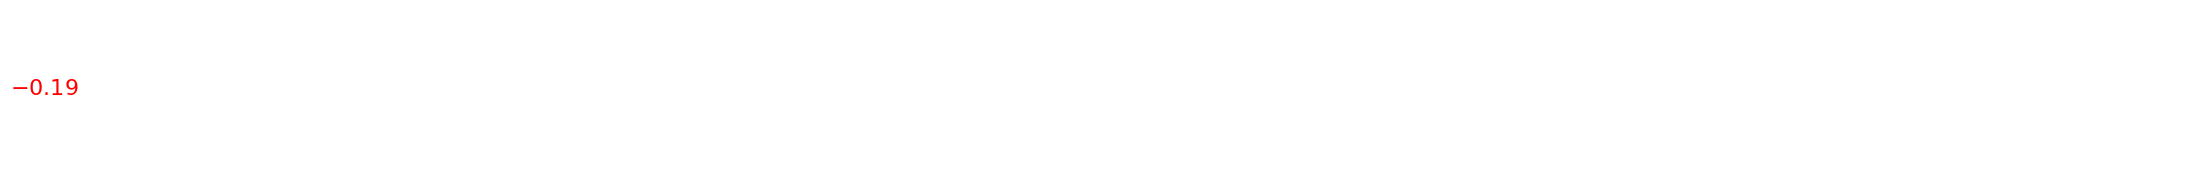

In [31]:
import numpy as np
import matplotlib
matplotlib.rcParams['text.usetex'] = True
from matplotlib import rc
rc("text", usetex=False)
import matplotlib.pyplot as plt


fig, ax = plt.subplots(figsize=(22, 2), tight_layout=True)
plt.axis('off')
ax.text(0,0.5,r'$'+formula_latex+'$', fontsize=16, color='r', )
plt.show()